#Defense systems and prophages that are present in less than 5% of the bacteria can hinder proper statistical analysis. 
#Intially, removing these elements to perform robust statistics

In [138]:
#load libraries

# Load required packages
import pandas as pd
import numpy as np
from dendropy import Tree
from dendropy.calculate.treemeasure import PatristicDistanceMatrix
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns


In [139]:
#load the tsv file with presence absence data

# Load presence/absence data and filter by prevalence
combined_df = pd.read_csv(
    '/Users/pjoglekar/work/pseudomonas/Pseudomonas_data_from_selected_genomes/pacbio_genomes/statistical_analysis/Converged_presence_absence_2.txt',
    index_col=0, sep='\t'
)
print(f"Loaded combined data: {combined_df.shape} (genomes * features)")

prevalence = combined_df.mean(axis=0)
keep_mask = prevalence >= 0.05
filtered_df = combined_df.loc[:, keep_mask]
removed_count = combined_df.shape[1] - filtered_df.shape[1]
print(f"Filtered out {removed_count} features (<5% prevalence). Remaining: {filtered_df.shape[1]}")

# Standardize genome names (replace spaces with underscores)
filtered_df.index = filtered_df.index.str.replace(' ', '_')

# Load phylogenetic tree
tree = Tree.get(
    path='/Users/pjoglekar/work/pseudomonas/Pseudomonas_data_from_selected_genomes/pacbio_genomes/statistical_analysis/core_gene_alignment_filtered_align2.newick',
    schema='newick'
)

Loaded combined data: (47, 157) (genomes * features)
Filtered out 83 features (<5% prevalence). Remaining: 74


In [140]:
#load phylogenetic tree

# Load phylogenetic tree
tree = Tree.get(
    path='/Users/pjoglekar/work/pseudomonas/Pseudomonas_data_from_selected_genomes/pacbio_genomes/statistical_analysis/core_gene_alignment_filtered_align2.newick',
    schema='newick'
)

# Get tree leaf labels (standardized)
tree_leaves = set(taxon.label.replace(' ', '_') for taxon in tree.taxon_namespace if taxon.label)
tsv_genomes = set(filtered_df.index)
common_genomes = sorted(tsv_genomes & tree_leaves)

if not common_genomes:
    print("No common genomes found.")
    print("TSV genomes (first 10):", sorted(tsv_genomes)[:10])
    print("Tree leaves (first 10):", sorted(tree_leaves)[:10])
    print("In TSV, not in tree:", sorted(tsv_genomes - tree_leaves))
    print("In tree, not in TSV:", sorted(tree_leaves - tsv_genomes))
    raise ValueError("No matching IDs. Check naming conventions.")

# Align filtered_df to common genomes
filtered_df = filtered_df.loc[common_genomes]
print(f"Aligned to {len(common_genomes)} common genomes.")
print(f"Missing in tree: {sorted(tsv_genomes - tree_leaves)}")
print(f"Missing in TSV: {sorted(tree_leaves - tsv_genomes)}")

# Compute pairwise phylogenetic distances using taxon objects
genomes = list(filtered_df.index)
pdm = PatristicDistanceMatrix(tree)
phylo_dists = []
pairs = []
missing_taxa = []

# Build a mapping from genome name to taxon object
taxon_map = {taxon.label.replace(' ', '_'): taxon for taxon in tree.taxon_namespace if taxon.label}

for i in range(len(genomes)):
    for j in range(i + 1, len(genomes)):
        taxon1 = taxon_map.get(genomes[i])
        taxon2 = taxon_map.get(genomes[j])
        if taxon1 is None or taxon2 is None:
            missing_taxa.append((genomes[i], genomes[j]))
            continue
        dist = pdm.distance(taxon1, taxon2)
        phylo_dists.append(dist)
        pairs.append((genomes[i], genomes[j]))

phylo_dists = np.array(phylo_dists)
print(f"Computed {len(phylo_dists)} pairwise phylogenetic distances.")
if missing_taxa:
    print(f"Warning: {len(missing_taxa)} genome pairs missing from tree. Example: {missing_taxa[:5]}")

# For debugging: print first few genome names and tree labels
print("TSV genomes (first 10):", genomes[:10])
print("Tree leaves (first 10):", sorted(tree_leaves)[:10])
print("In TSV, not in tree:", sorted(tsv_genomes - tree_leaves))
print("In tree, not in TSV:", sorted(tree_leaves - tsv_genomes))

Aligned to 47 common genomes.
Missing in tree: []
Missing in TSV: []
Computed 1081 pairwise phylogenetic distances.
TSV genomes (first 10): ['P._allivorans_Cu1_NCSU_AHP196', 'P._amygdali_pv._seasami_LMG2289', 'P._amygdali_pv._sesame', 'P._avellanae_NCSU_AHP188', 'P._boreofloridenis_K13_NCSU_AHP193', 'P._cannabina_ICMP2823', 'P._capsici_AS1_NCSU_AHP195', 'P._capsici_NCSU_AHP167', 'P._caricapapayae_ICMP2855', 'P._cerasi_NCSU_AHP175']
Tree leaves (first 10): ['P._allivorans_Cu1_NCSU_AHP196', 'P._amygdali_pv._seasami_LMG2289', 'P._amygdali_pv._sesame', 'P._avellanae_NCSU_AHP188', 'P._boreofloridenis_K13_NCSU_AHP193', 'P._cannabina_ICMP2823', 'P._capsici_AS1_NCSU_AHP195', 'P._capsici_NCSU_AHP167', 'P._caricapapayae_ICMP2855', 'P._cerasi_NCSU_AHP175']
In TSV, not in tree: []
In tree, not in TSV: []


/var/folders/mq/_l9mkmz93m7fl34hxpwjm23h0000gt/T/ipykernel_89612/1691495568.py:30: CriticalDeprecationWarning: PatristicDistanceMatrix is deprecated since Dendropy 5. Use entropy. phylogenetic distance.PhylogeneticDistanceMatrix instead.
  pdm = PatristicDistanceMatrix(tree)


Computed 1081 pairwise Jaccard distances.
Spearman correlation coefficient (rho): 0.6588
P-value: 1.6184e-135


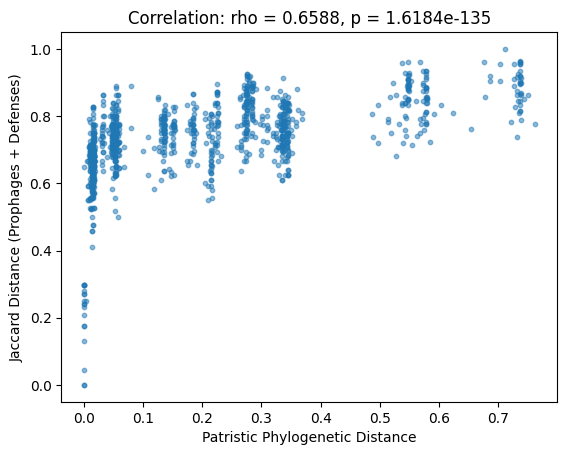

Results saved to 'distance_results.csv'.


In [141]:
# Step 5: Compute Pairwise Jaccard Distances
jaccard_matrix = squareform(pdist(filtered_df.values, metric='jaccard'))
jaccard_dists = [jaccard_matrix[genomes.index(g1), genomes.index(g2)] for g1, g2 in pairs]
jaccard_dists = np.array(jaccard_dists)
print(f"Computed {len(jaccard_dists)} pairwise Jaccard distances.")

# Step 6: Spearman Correlation
if len(phylo_dists) == 0:
    raise ValueError("No valid phylogenetic distances. Check taxon labels.")
rho, p_value = spearmanr(phylo_dists, jaccard_dists, nan_policy='omit')
print(f"Spearman correlation coefficient (rho): {rho:.4f}")
print(f"P-value: {p_value:.4e}")

# Step 7: Visualize
plt.scatter(phylo_dists, jaccard_dists, alpha=0.5, s=10)
plt.xlabel('Patristic Phylogenetic Distance')
plt.ylabel('Jaccard Distance (Prophages + Defenses)')
plt.title(f'Correlation: rho = {rho:.4f}, p = {p_value:.4e}')
plt.savefig('correlation_plot.png')
plt.show()

# Step 8: Save Results
results_df = pd.DataFrame({
    'Genome1': [p[0] for p in pairs],
    'Genome2': [p[1] for p in pairs],
    'Phylogenetic_Distance': phylo_dists,
    'Jaccard_Distance': jaccard_dists
})
results_df.to_csv('distance_results.csv', index=False)
print("Results saved to 'distance_results.csv'.")


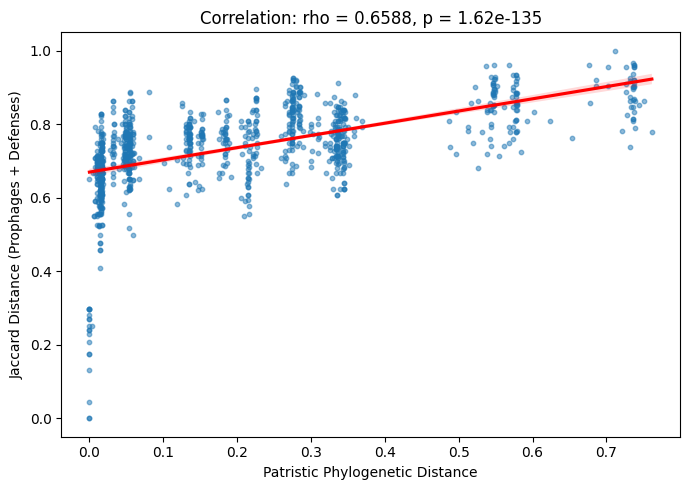

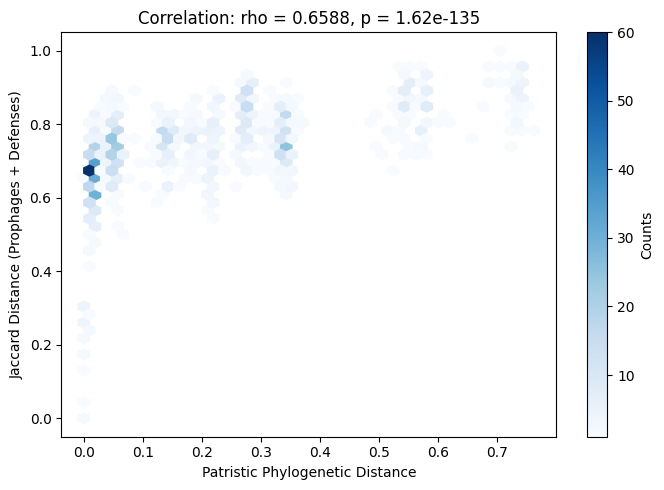

Phylogenetic Distance: mean=0.199, median=0.143, std=0.197
Jaccard Distance: mean=0.736, median=0.750, std=0.116


In [142]:
#graphs attempt 2
plt.figure(figsize=(7,5))
sns.regplot(x=phylo_dists, y=jaccard_dists, scatter_kws={'s':10, 'alpha':0.5}, line_kws={'color':'red'})
plt.xlabel('Patristic Phylogenetic Distance')
plt.ylabel('Jaccard Distance (Prophages + Defenses)')
plt.title(f'Correlation: rho = {rho:.4f}, p = {p_value:.2e}')
plt.tight_layout()
plt.savefig('correlation_plot_with_trend.png')
plt.show()


plt.figure(figsize=(7,5))
plt.hexbin(phylo_dists, jaccard_dists, gridsize=40, cmap='Blues', mincnt=1)
plt.colorbar(label='Counts')
plt.xlabel('Patristic Phylogenetic Distance')
plt.ylabel('Jaccard Distance (Prophages + Defenses)')
plt.title(f'Correlation: rho = {rho:.4f}, p = {p_value:.2e}')
plt.tight_layout()
plt.savefig('correlation_hexbin.png')
plt.show()

print("Phylogenetic Distance: mean={:.3f}, median={:.3f}, std={:.3f}".format(
    np.mean(phylo_dists), np.median(phylo_dists), np.std(phylo_dists)))
print("Jaccard Distance: mean={:.3f}, median={:.3f}, std={:.3f}".format(
    np.mean(jaccard_dists), np.median(jaccard_dists), np.std(jaccard_dists)))

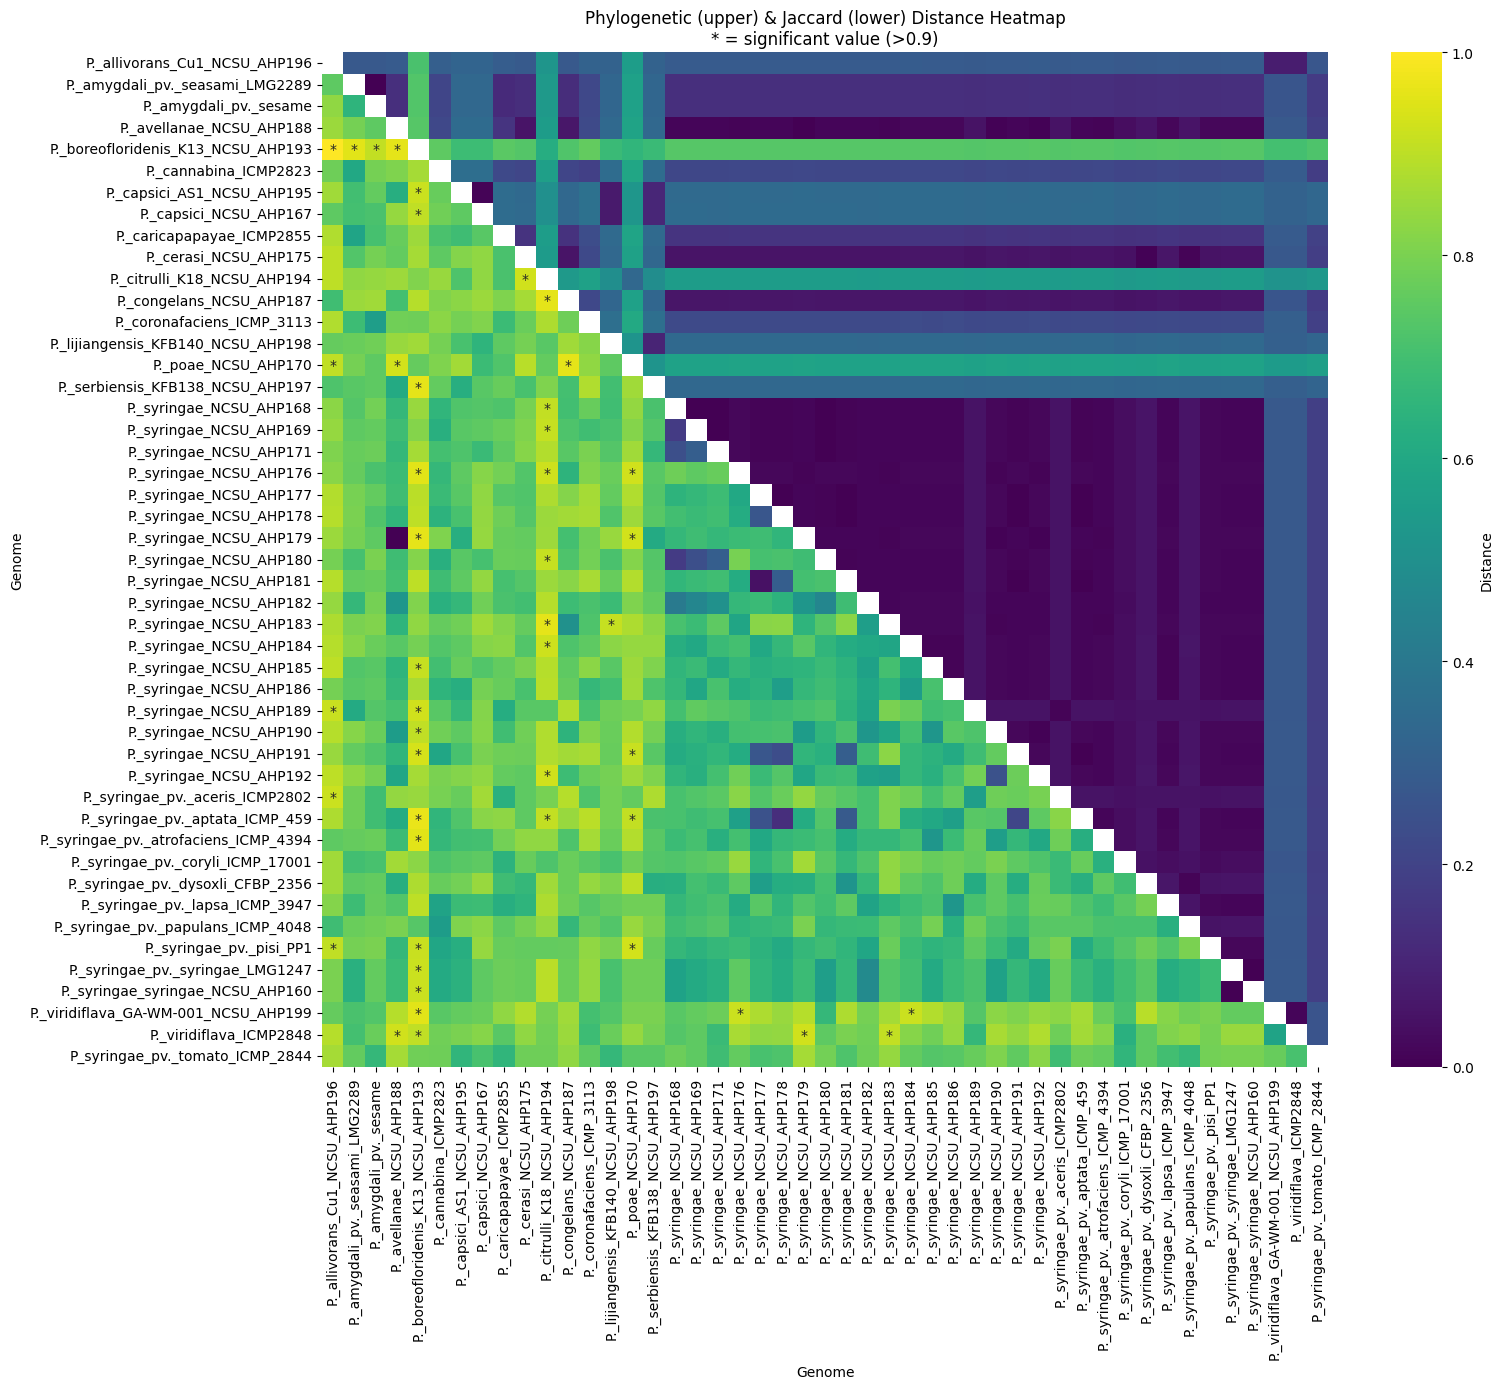

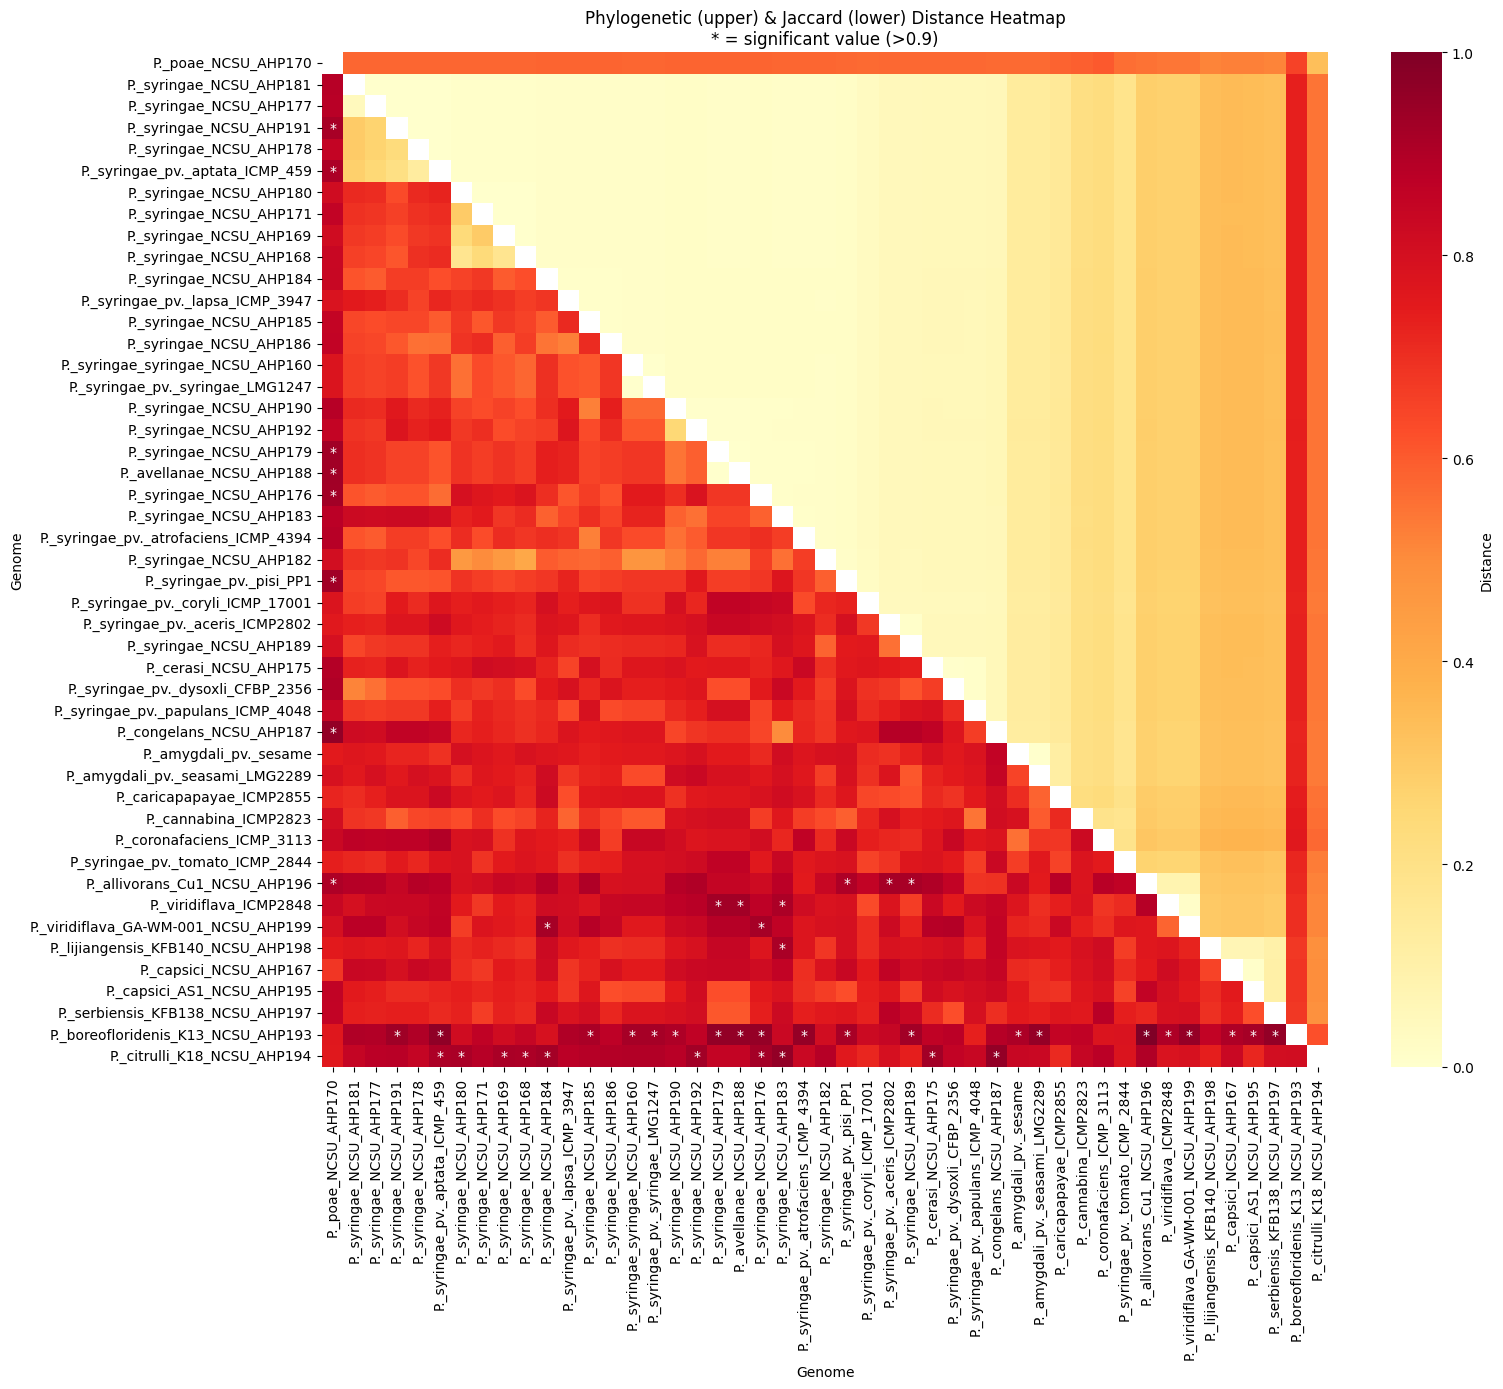

In [143]:
#heatmap for distances

#using the results produced in earlier step
df=results_df

#get unique genome name
genomes = sorted(set(df['Genome1']).union(df['Genome2']))

#Create empty matrices
phylo_matrix = pd.DataFrame(np.nan, index=genomes, columns=genomes)
jaccard_matrix = pd.DataFrame(np.nan, index=genomes, columns=genomes)

# Fill matrices
for _, row in df.iterrows():
    g1, g2 = row['Genome1'], row['Genome2']
    phylo_matrix.loc[g1, g2] = row['Phylogenetic_Distance']
    phylo_matrix.loc[g2, g1] = row['Phylogenetic_Distance']
    jaccard_matrix.loc[g1, g2] = row['Jaccard_Distance']
    jaccard_matrix.loc[g2, g1] = row['Jaccard_Distance']

# Create a combined matrix: upper triangle = phylo, lower triangle = jaccard
combined = phylo_matrix.copy()
for i in range(len(genomes)):
    for j in range(len(genomes)):
        if i > j:
            combined.iloc[i, j] = jaccard_matrix.iloc[i, j]

# Optionally, highlight significant values (e.g., Jaccard > 0.9 or Phylo > 0.7)
def significance_mask(matrix, threshold):
    mask = np.full(matrix.shape, '', dtype=object)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if i > j and jaccard_matrix.iloc[i, j] > threshold:
                mask[i, j] = '*'
            elif i < j and phylo_matrix.iloc[i, j] > threshold:
                mask[i, j] = '*'
    return mask

mask = significance_mask(combined, threshold=0.9)

plt.figure(figsize=(16, 14))
ax = sns.heatmap(combined, cmap='viridis', annot=mask, fmt='', cbar_kws={'label': 'Distance'})
plt.title('Phylogenetic (upper) & Jaccard (lower) Distance Heatmap\n* = significant value (>0.9)')
plt.xlabel('Genome')
plt.ylabel('Genome')
plt.tight_layout()
plt.savefig('split_heatmap.png')
plt.show()

#order Xaxis based on tree

# Get ordered genome names from the tree (standardized)
ordered_genomes = [taxon.label.replace(' ', '_') for taxon in tree.taxon_namespace if taxon.label]

# Filter to only those present in your results
ordered_genomes = [g for g in ordered_genomes if g in genomes]

# Recreate matrices using ordered_genomes
phylo_matrix = pd.DataFrame(np.nan, index=ordered_genomes, columns=ordered_genomes)
jaccard_matrix = pd.DataFrame(np.nan, index=ordered_genomes, columns=ordered_genomes)

for _, row in df.iterrows():
    g1, g2 = row['Genome1'], row['Genome2']
    if g1 in ordered_genomes and g2 in ordered_genomes:
        phylo_matrix.loc[g1, g2] = row['Phylogenetic_Distance']
        phylo_matrix.loc[g2, g1] = row['Phylogenetic_Distance']
        jaccard_matrix.loc[g1, g2] = row['Jaccard_Distance']
        jaccard_matrix.loc[g2, g1] = row['Jaccard_Distance']

# Create combined matrix as before
combined = phylo_matrix.copy()
for i in range(len(ordered_genomes)):
    for j in range(len(ordered_genomes)):
        if i > j:
            combined.iloc[i, j] = jaccard_matrix.iloc[i, j]

# Mask for significant values
mask = significance_mask(combined, threshold=0.9)

plt.figure(figsize=(16, 14))

#upper triangle
ax = sns.heatmap(
    combined,
    cmap='YlOrRd',  # yellow-orange-red
    annot=mask,
    fmt='',
    cbar_kws={'label': 'Distance'}
)
plt.title('Phylogenetic (upper) & Jaccard (lower) Distance Heatmap\n* = significant value (>0.9)')
plt.xlabel('Genome')
plt.ylabel('Genome')
plt.tight_layout()
plt.savefig('split_heatmap.png')
plt.show()


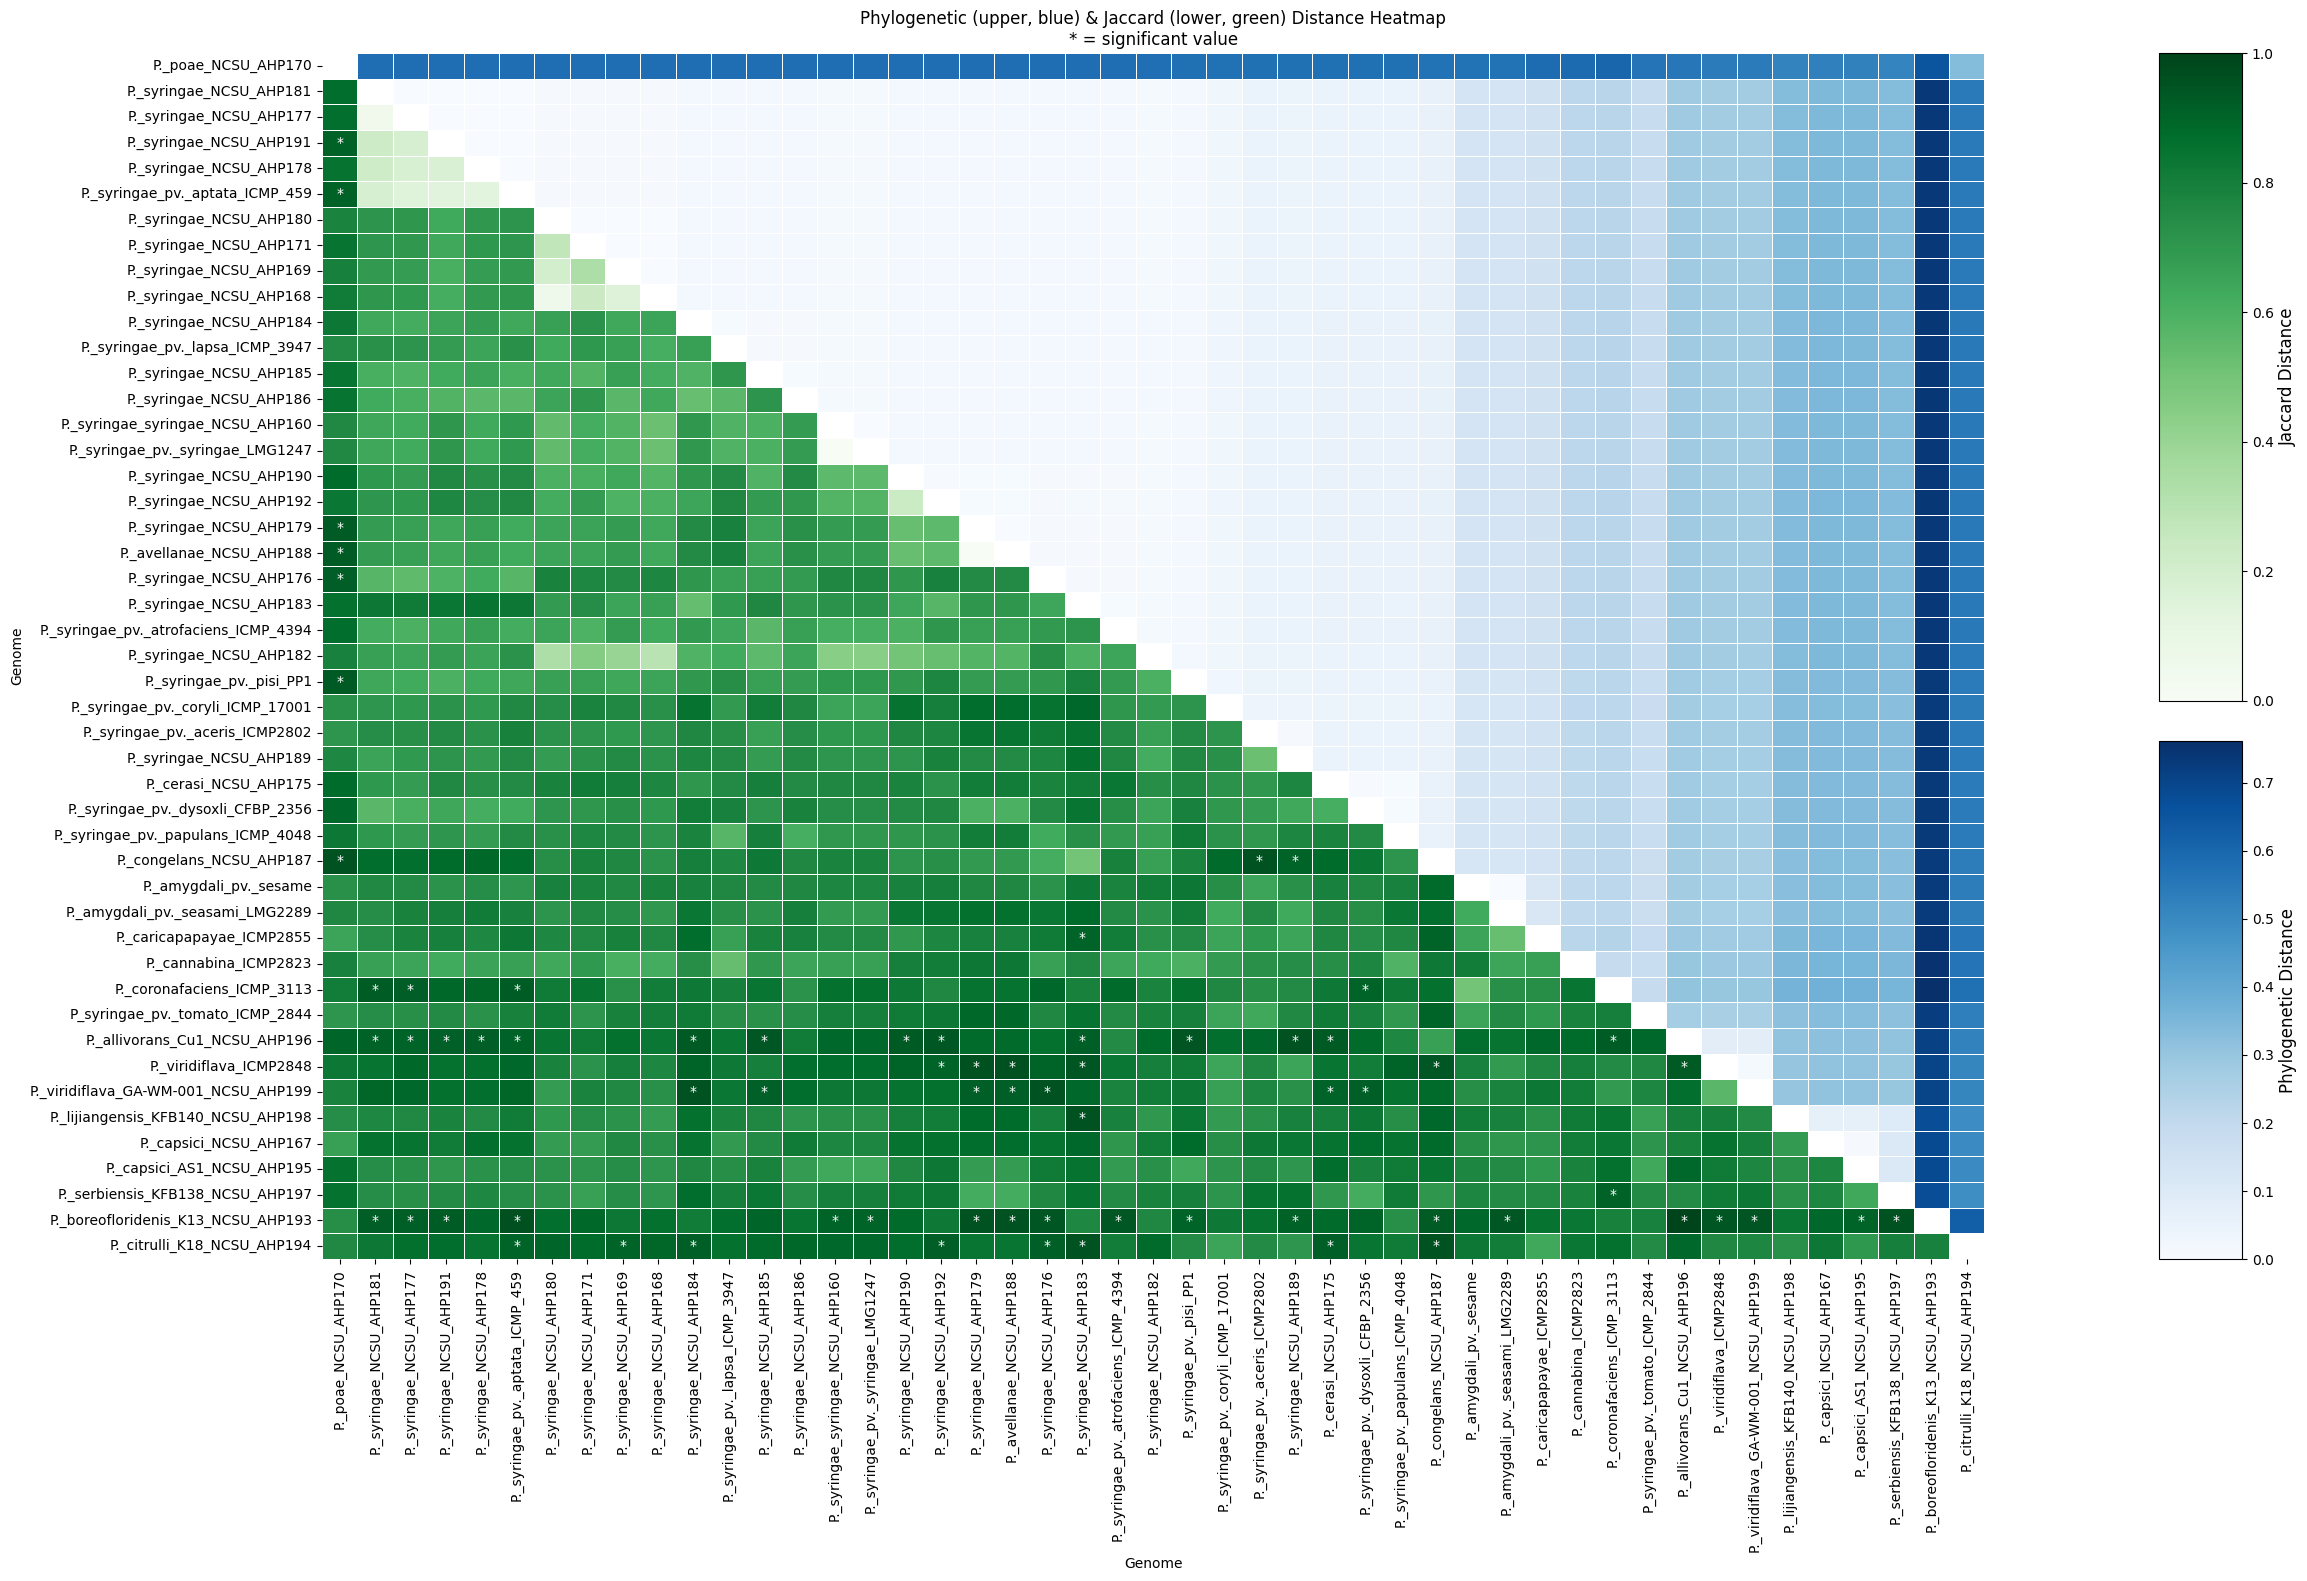

In [210]:
#edit 3

import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec


# Create a custom colormap: blues for upper triangle, greens for lower triangle
from matplotlib.colors import ListedColormap

# Prepare the combined matrix as before
combined = phylo_matrix.copy()
for i in range(len(ordered_genomes)):
    for j in range(len(ordered_genomes)):
        if i > j:
            combined.iloc[i, j] = jaccard_matrix.iloc[i, j]

lower_mask = np.tril(np.ones(combined.shape), k=-1).astype(bool)
upper_mask = np.triu(np.ones(combined.shape), k=1).astype(bool)
greens = plt.get_cmap('Greens')
blues = plt.get_cmap('Blues')

fig = plt.figure(figsize=(16, 14))
gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1], wspace=0.2)

# Main heatmap axis
ax = fig.add_subplot(gs[0])

# Plot lower triangle (Jaccard, greens) without colorbar
sns.heatmap(
    combined.where(lower_mask),
    cmap=greens,
    cbar=False,
    annot=mask,
    fmt='',
    linewidths=0.5,
    ax=ax
)

# Plot upper triangle (Phylogenetic, blues) without colorbar
sns.heatmap(
    combined.where(upper_mask),
    cmap=blues,
    cbar=False,
    annot=mask,
    fmt='',
    linewidths=0.5,
    ax=ax
)

plt.title('Phylogenetic (upper, blue) & Jaccard (lower, green) Distance Heatmap\n* = significant value')
plt.xlabel('Genome')
plt.ylabel('Genome')

# Add Jaccard colorbar (green) on the right
cbar_ax1 = fig.add_subplot(gs[1])
norm_g = plt.Normalize(vmin=np.nanmin(jaccard_matrix.values), vmax=np.nanmax(jaccard_matrix.values))
cb1 = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm_g, cmap=greens),
    cax=cbar_ax1,
    orientation='vertical'
)
cb1.set_label('Jaccard Distance', fontsize=12)
cb1.ax.tick_params(labelsize=10)

# Add Phylogenetic colorbar (blue) below the Jaccard colorbar (on the right)
# Use a new axes below the first colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(cbar_ax1)
cbar_ax2 = divider.append_axes("bottom", size="80%", pad=0.4)
norm_b = plt.Normalize(vmin=np.nanmin(phylo_matrix.values), vmax=np.nanmax(phylo_matrix.values))
cb2 = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm_b, cmap=blues),
    cax=cbar_ax2,
    orientation='vertical'
)
cb2.set_label('Phylogenetic Distance', fontsize=12)
cb2.ax.tick_params(labelsize=10)

fig.set_size_inches(24, 18)  # Increase figure size
plt.subplots_adjust(left=0.15, right=0.95, top=0.92, bottom=0.25)  # Adjust margins
plt.savefig('split_heatmap_green_blue_right_legends.png', bbox_inches='tight')
plt.show()

**Jaccard Distance**
*What it measures:*
The Jaccard distance quantifies how different two sets are. In this context, it measures how different the presence/absence patterns of prophages and defense systems are between two genomes.

`Jaccard distance = 1 - (number of shared features / number of total features present in either genome)`

_**Calculation:**_
For two genomes, it is calculated as:
If two genomes have exactly the same features, Jaccard distance = 0 (they are identical).
If they have no features in common, Jaccard distance = 1 (completely different).

**Phylogenetic Distance**
*What it measures:*
Phylogenetic distance quantifies how far apart two genomes are on the evolutionary tree. It is based on the sum of branch lengths connecting the two genomes in the phylogenetic tree.
_**Calculation:**_
For two genomes, it is the sum of the branch lengths from each genome to their most recent common ancestor.
A small phylogenetic distance means the genomes are closely related.
A large phylogenetic distance means they are distantly related.


**Summary:**
Jaccard distance: Measures difference in gene content (prophages/defenses) between genomes.
Phylogenetic distance: Measures evolutionary separation between genomes.

In [211]:
#Redoing the analysis for Phage alone

# Load presence/absence data and filter by prevalence
phage_df = pd.read_csv(
    '/Users/pjoglekar/work/pseudomonas/Pseudomonas_data_from_selected_genomes/pacbio_genomes/statistical_analysis/Converged_prophage_presence_absence_2.txt',
    index_col=0, sep='\t'
)
print(f"Loaded phage data: {phage_df.shape} (genomes * features)")

prevalence = phage_df.mean(axis=0)
keep_mask = prevalence >= 0.05
filtered_phage_df = phage_df.loc[:, keep_mask]  # Only filter columns, not rows
removed_phage_count = phage_df.shape[1] - filtered_phage_df.shape[1]
print(f"Filtered out {removed_phage_count} features (<5% prevalence). Remaining: {filtered_phage_df.shape[1]}")

Loaded phage data: (47, 23) (genomes * features)
Filtered out 12 features (<5% prevalence). Remaining: 11


Aligned to 47 common genomes.
Missing in tree: []
Missing in TSV: []
Computed 1081 pairwise Jaccard distances.
Spearman correlation coefficient (rho): 0.2209
P-value: 2.0438e-13


/var/folders/mq/_l9mkmz93m7fl34hxpwjm23h0000gt/T/ipykernel_89612/1535262438.py:24: CriticalDeprecationWarning: PatristicDistanceMatrix is deprecated since Dendropy 5. Use entropy. phylogenetic distance.PhylogeneticDistanceMatrix instead.
  pdm = PatristicDistanceMatrix(tree)


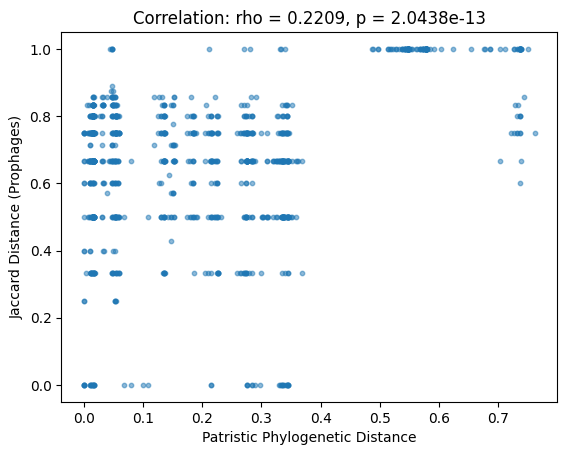

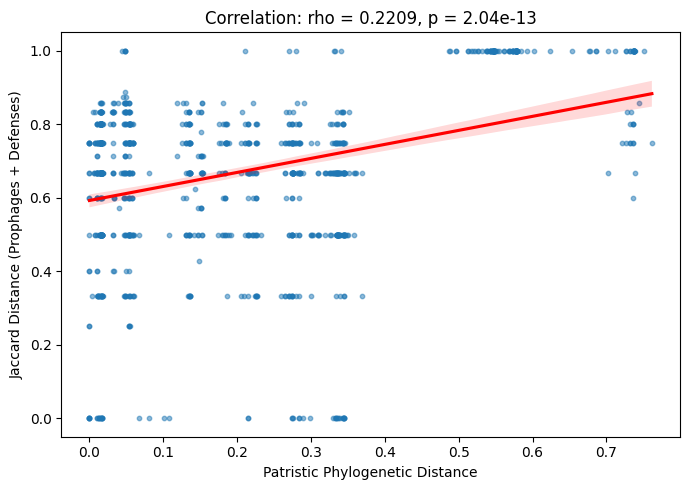

Results saved to 'phage_distance_results.csv'.


In [212]:
# Get tree leaf labels (standardized)
# Standardize genome names (replace spaces with underscores)
filtered_phage_df.index = filtered_phage_df.index.str.replace(' ', '_')
tree_leaves = set(taxon.label.replace(' ', '_') for taxon in tree.taxon_namespace if taxon.label)
tsv_genomes = set(filtered_phage_df.index)
common_genomes = sorted(tsv_genomes & tree_leaves)

if not common_genomes:
    print("No common genomes found.")
    print("TSV genomes (first 10):", sorted(tsv_genomes)[:10])
    print("Tree leaves (first 10):", sorted(tree_leaves)[:10])
    print("In TSV, not in tree:", sorted(tsv_genomes - tree_leaves))
    print("In tree, not in TSV:", sorted(tree_leaves - tsv_genomes))
    raise ValueError("No matching IDs. Check naming conventions.")

# Align filtered_df to common genomes
filtered_phage_df = filtered_phage_df.loc[common_genomes]
print(f"Aligned to {len(common_genomes)} common genomes.")
print(f"Missing in tree: {sorted(tsv_genomes - tree_leaves)}")
print(f"Missing in TSV: {sorted(tree_leaves - tsv_genomes)}")

# # Compute pairwise phylogenetic distances using taxon objects
genomes = list(filtered_phage_df.index)
pdm = PatristicDistanceMatrix(tree)
phage_phylo_dists = []
pairs = []
missing_taxa = []

for i in range(len(genomes)):
    for j in range(i + 1, len(genomes)):
        taxon1 = taxon_map.get(genomes[i])
        taxon2 = taxon_map.get(genomes[j])
        if taxon1 is None or taxon2 is None:
            missing_taxa.append((genomes[i], genomes[j]))
            continue
        dist = pdm.distance(taxon1, taxon2)
        phage_phylo_dists.append(dist)
        pairs.append((genomes[i], genomes[j]))

# # Step 5: Compute Pairwise Jaccard Distances
jaccard_matrix = squareform(pdist(filtered_phage_df.values, metric='jaccard'))
jaccard_dists = [jaccard_matrix[genomes.index(g1), genomes.index(g2)] for g1, g2 in pairs]
jaccard_dists = np.array(jaccard_dists)
print(f"Computed {len(jaccard_dists)} pairwise Jaccard distances.")

# # Step 6: Spearman Correlation
if len(phage_phylo_dists) == 0:
    raise ValueError("No valid phylogenetic distances. Check taxon labels.")
rho, p_value = spearmanr(phage_phylo_dists, jaccard_dists, nan_policy='omit')
print(f"Spearman correlation coefficient (rho): {rho:.4f}")
print(f"P-value: {p_value:.4e}")

# # Step 7: Visualize
plt.scatter(phage_phylo_dists, jaccard_dists, alpha=0.5, s=10)
plt.xlabel('Patristic Phylogenetic Distance')
plt.ylabel('Jaccard Distance (Prophages)')
plt.title(f'Correlation: rho = {rho:.4f}, p = {p_value:.4e}')
plt.savefig('phage_correlation_plot.png')
plt.show()

plt.figure(figsize=(7,5))
sns.regplot(x=phage_phylo_dists, y=jaccard_dists, scatter_kws={'s':10, 'alpha':0.5}, line_kws={'color':'red'})
plt.xlabel('Patristic Phylogenetic Distance')
plt.ylabel('Jaccard Distance (Prophages + Defenses)')
plt.title(f'Correlation: rho = {rho:.4f}, p = {p_value:.2e}')
plt.tight_layout()
plt.savefig('correlation_plot_with_trend.png')
plt.show()

phage_results_df = pd.DataFrame({
    'Genome1': [p[0] for p in pairs],
    'Genome2': [p[1] for p in pairs],
    'Phylogenetic_Distance': phage_phylo_dists,
    'Jaccard_Distance': jaccard_dists
})
results_df.to_csv('phage_distance_results.csv', index=False)
print("Results saved to 'phage_distance_results.csv'.")


/var/folders/mq/_l9mkmz93m7fl34hxpwjm23h0000gt/T/ipykernel_89612/2153806428.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 1])


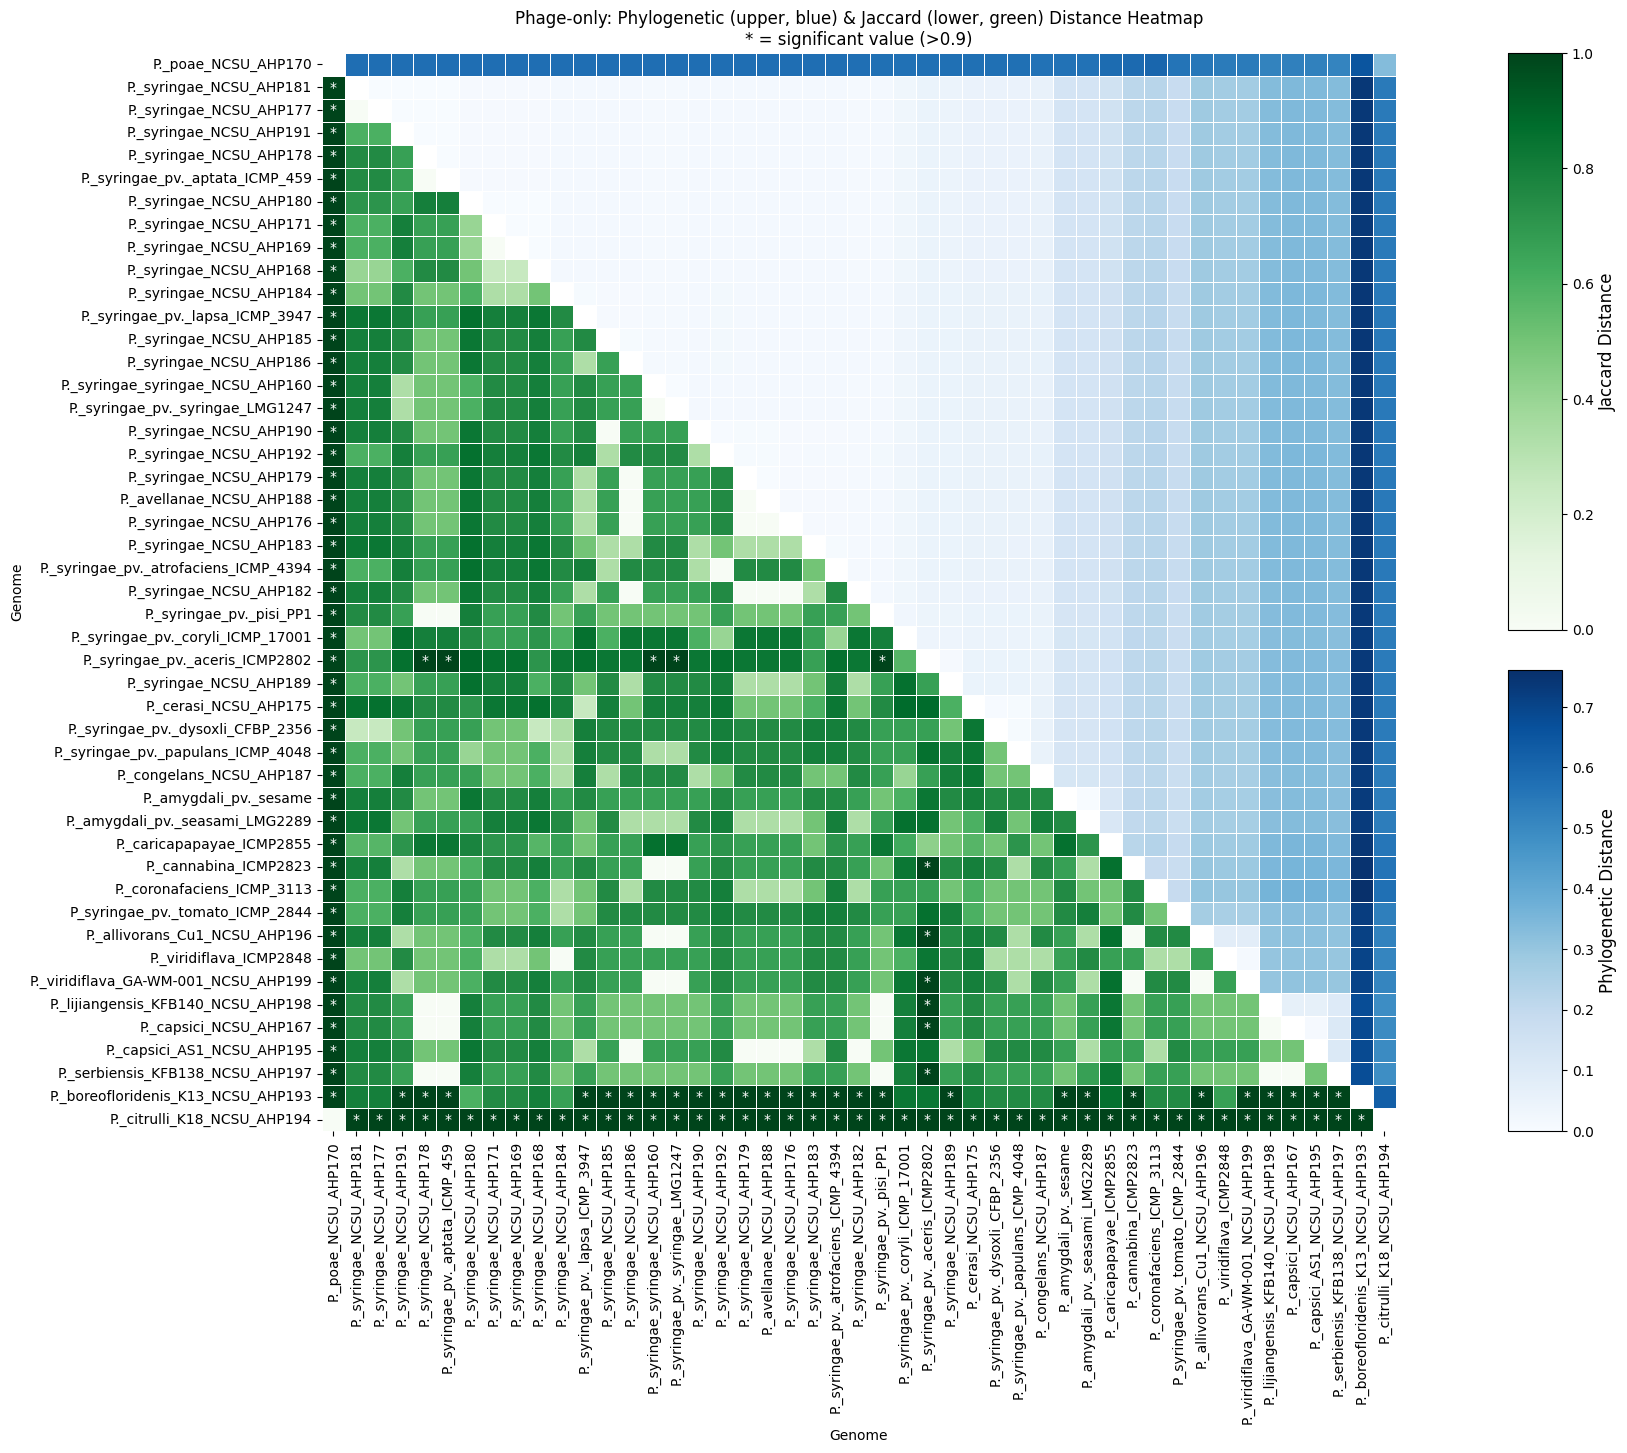

In [213]:
# Use phage_results_df for phage-only heatmap
df = phage_results_df

# Get unique genome names
genomes = sorted(set(df['Genome1']).union(df['Genome2']))

# Create empty matrices
phylo_matrix = pd.DataFrame(np.nan, index=genomes, columns=genomes)
jaccard_matrix = pd.DataFrame(np.nan, index=genomes, columns=genomes)

# Fill matrices
for _, row in df.iterrows():
    g1, g2 = row['Genome1'], row['Genome2']
    phylo_matrix.loc[g1, g2] = row['Phylogenetic_Distance']
    phylo_matrix.loc[g2, g1] = row['Phylogenetic_Distance']
    jaccard_matrix.loc[g1, g2] = row['Jaccard_Distance']
    jaccard_matrix.loc[g2, g1] = row['Jaccard_Distance']

# Order genomes by tree
ordered_genomes = [taxon.label.replace(' ', '_') for taxon in tree.taxon_namespace if taxon.label]
ordered_genomes = [g for g in ordered_genomes if g in genomes]

# Recreate matrices using ordered_genomes
phylo_matrix = pd.DataFrame(np.nan, index=ordered_genomes, columns=ordered_genomes)
jaccard_matrix = pd.DataFrame(np.nan, index=ordered_genomes, columns=ordered_genomes)

for _, row in df.iterrows():
    g1, g2 = row['Genome1'], row['Genome2']
    if g1 in ordered_genomes and g2 in ordered_genomes:
        phylo_matrix.loc[g1, g2] = row['Phylogenetic_Distance']
        phylo_matrix.loc[g2, g1] = row['Phylogenetic_Distance']
        jaccard_matrix.loc[g1, g2] = row['Jaccard_Distance']
        jaccard_matrix.loc[g2, g1] = row['Jaccard_Distance']

# Create combined matrix: upper triangle = phylo, lower triangle = jaccard
combined = phylo_matrix.copy()
for i in range(len(ordered_genomes)):
    for j in range(len(ordered_genomes)):
        if i > j:
            combined.iloc[i, j] = jaccard_matrix.iloc[i, j]

# Mask for significant values
def significance_mask(matrix, threshold):
    mask = np.full(matrix.shape, '', dtype=object)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if i > j and jaccard_matrix.iloc[i, j] > threshold:
                mask[i, j] = '*'
            elif i < j and phylo_matrix.iloc[i, j] > threshold:
                mask[i, j] = '*'
    return mask

mask = significance_mask(combined, threshold=0.9)

import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

# Half green/half blue plot
greens = plt.get_cmap('Greens')
blues = plt.get_cmap('Blues')
lower_mask = np.tril(np.ones(combined.shape), k=-1).astype(bool)
upper_mask = np.triu(np.ones(combined.shape), k=1).astype(bool)

fig = plt.figure(figsize=(16, 14))
gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1], wspace=0.2)
ax = fig.add_subplot(gs[0])

# Lower triangle (Jaccard, green)
sns.heatmap(
    combined.where(lower_mask),
    cmap=greens,
    cbar=False,
    annot=mask,
    fmt='',
    linewidths=0.5,
    ax=ax
)

# Upper triangle (Phylogenetic, blue)
sns.heatmap(
    combined.where(upper_mask),
    cmap=blues,
    cbar=False,
    annot=mask,
    fmt='',
    linewidths=0.5,
    ax=ax
)

plt.title('Phage-only: Phylogenetic (upper, blue) & Jaccard (lower, green) Distance Heatmap\n* = significant value (>0.9)')
plt.xlabel('Genome')
plt.ylabel('Genome')

# Add Jaccard colorbar (green) on the right
cbar_ax1 = fig.add_subplot(gs[1])
norm_g = plt.Normalize(vmin=np.nanmin(jaccard_matrix.values), vmax=np.nanmax(jaccard_matrix.values))
cb1 = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm_g, cmap=greens),
    cax=cbar_ax1,
    orientation='vertical'
)
cb1.set_label('Jaccard Distance', fontsize=12)
cb1.ax.tick_params(labelsize=10)

# Add Phylogenetic colorbar (blue) below the Jaccard colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(cbar_ax1)
cbar_ax2 = divider.append_axes("bottom", size="80%", pad=0.4)
norm_b = plt.Normalize(vmin=np.nanmin(phylo_matrix.values), vmax=np.nanmax(phylo_matrix.values))
cb2 = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm_b, cmap=blues),
    cax=cbar_ax2,
    orientation='vertical'
)
cb2.set_label('Phylogenetic Distance', fontsize=12)
cb2.ax.tick_params(labelsize=10)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig('phage_split_heatmap_green_blue_right_legends.png')
plt.show()

Loaded PADLOC data: (47, 134) (genomes * features)
Filtered out 71 features (<5% prevalence). Remaining: 63
Aligned to 47 common genomes.
Spearman correlation coefficient (rho): 0.6414
P-value: 2.4879e-126
Results saved to 'padloc_distance_results.csv'.


/var/folders/mq/_l9mkmz93m7fl34hxpwjm23h0000gt/T/ipykernel_89612/1768923940.py:26: CriticalDeprecationWarning: PatristicDistanceMatrix is deprecated since Dendropy 5. Use entropy. phylogenetic distance.PhylogeneticDistanceMatrix instead.
  pdm = PatristicDistanceMatrix(tree)
/var/folders/mq/_l9mkmz93m7fl34hxpwjm23h0000gt/T/ipykernel_89612/1768923940.py:157: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 1])


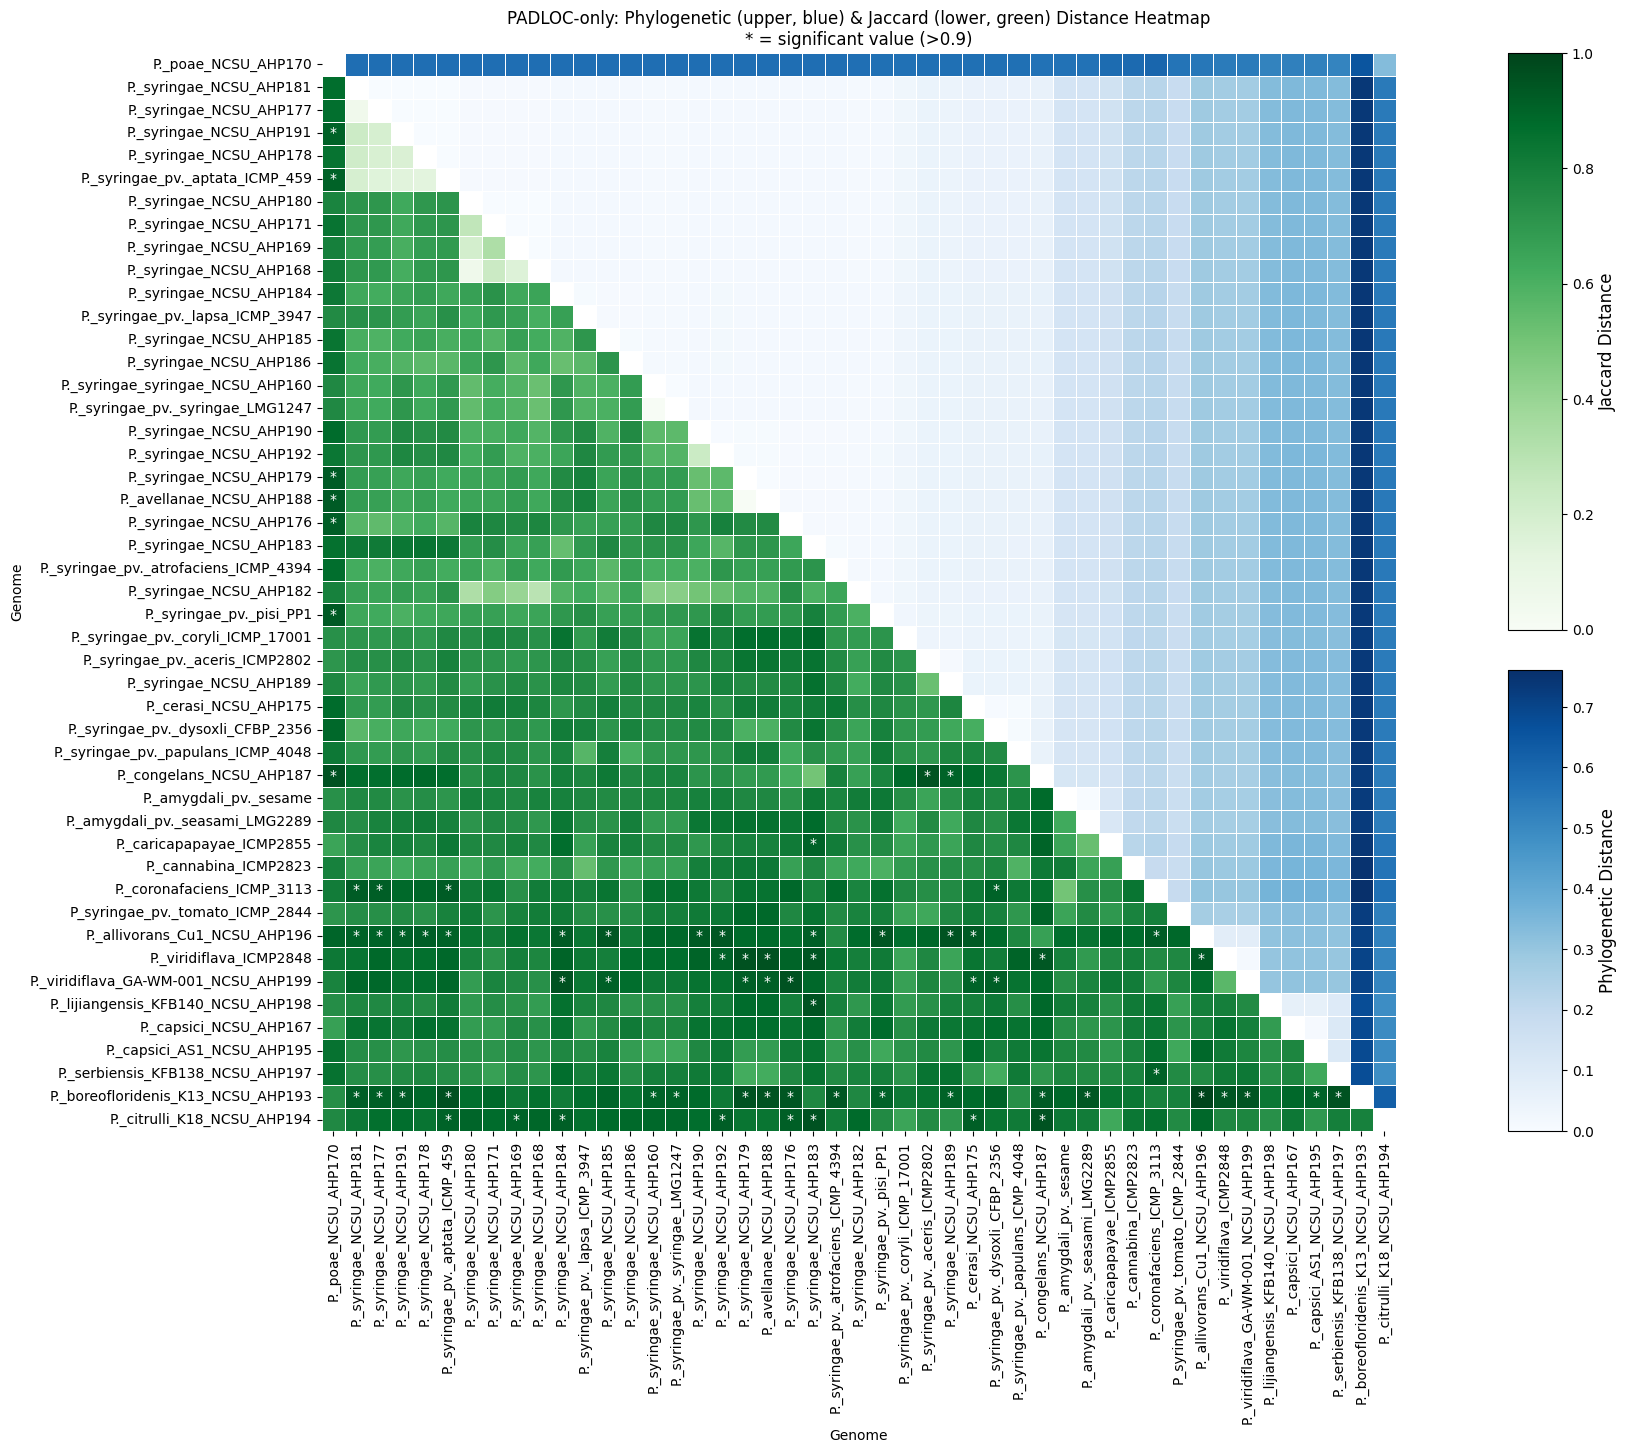

In [214]:
# PADLOC-only analysis

# Load PADLOC presence/absence data and filter by prevalence
padloc_df = pd.read_csv(
    '/Users/pjoglekar/work/pseudomonas/Pseudomonas_data_from_selected_genomes/pacbio_genomes/statistical_analysis/Converged_padloc_presence_absence_2.txt',
    index_col=0, sep='\t'
)
print(f"Loaded PADLOC data: {padloc_df.shape} (genomes * features)")

prevalence = padloc_df.mean(axis=0)
keep_mask = prevalence >= 0.05
filtered_padloc_df = padloc_df.loc[:, keep_mask]
removed_padloc_count = padloc_df.shape[1] - filtered_padloc_df.shape[1]
print(f"Filtered out {removed_padloc_count} features (<5% prevalence). Remaining: {filtered_padloc_df.shape[1]}")

# Standardize genome names
filtered_padloc_df.index = filtered_padloc_df.index.str.replace(' ', '_')
tree_leaves = set(taxon.label.replace(' ', '_') for taxon in tree.taxon_namespace if taxon.label)
tsv_genomes = set(filtered_padloc_df.index)
common_genomes = sorted(tsv_genomes & tree_leaves)
filtered_padloc_df = filtered_padloc_df.loc[common_genomes]
print(f"Aligned to {len(common_genomes)} common genomes.")

# Compute pairwise phylogenetic distances
genomes = list(filtered_padloc_df.index)
pdm = PatristicDistanceMatrix(tree)
padloc_phylo_dists = []
pairs = []
for i in range(len(genomes)):
    for j in range(i + 1, len(genomes)):
        taxon1 = taxon_map.get(genomes[i])
        taxon2 = taxon_map.get(genomes[j])
        if taxon1 is None or taxon2 is None:
            continue
        dist = pdm.distance(taxon1, taxon2)
        padloc_phylo_dists.append(dist)
        pairs.append((genomes[i], genomes[j]))

# Compute pairwise Jaccard distances
jaccard_matrix = squareform(pdist(filtered_padloc_df.values, metric='jaccard'))
jaccard_dists = [jaccard_matrix[genomes.index(g1), genomes.index(g2)] for g1, g2 in pairs]

# Correlation
from scipy.stats import spearmanr
rho, p_value = spearmanr(padloc_phylo_dists, jaccard_dists, nan_policy='omit')
print(f"Spearman correlation coefficient (rho): {rho:.4f}")
print(f"P-value: {p_value:.4e}")

# Save results
padloc_results_df = pd.DataFrame({
    'Genome1': [p[0] for p in pairs],
    'Genome2': [p[1] for p in pairs],
    'Phylogenetic_Distance': padloc_phylo_dists,
    'Jaccard_Distance': jaccard_dists
})
padloc_results_df.to_csv('padloc_distance_results.csv', index=False)
print("Results saved to 'padloc_distance_results.csv'.")

# Heatmap for PADLOC-only
df = padloc_results_df
genomes = sorted(set(df['Genome1']).union(df['Genome2']))
phylo_matrix = pd.DataFrame(np.nan, index=genomes, columns=genomes)
jaccard_matrix = pd.DataFrame(np.nan, index=genomes, columns=genomes)
for _, row in df.iterrows():
    g1, g2 = row['Genome1'], row['Genome2']
    phylo_matrix.loc[g1, g2] = row['Phylogenetic_Distance']
    phylo_matrix.loc[g2, g1] = row['Phylogenetic_Distance']
    jaccard_matrix.loc[g1, g2] = row['Jaccard_Distance']
    jaccard_matrix.loc[g2, g1] = row['Jaccard_Distance']

ordered_genomes = [taxon.label.replace(' ', '_') for taxon in tree.taxon_namespace if taxon.label]
ordered_genomes = [g for g in ordered_genomes if g in genomes]
phylo_matrix = pd.DataFrame(np.nan, index=ordered_genomes, columns=ordered_genomes)
jaccard_matrix = pd.DataFrame(np.nan, index=ordered_genomes, columns=ordered_genomes)
for _, row in df.iterrows():
    g1, g2 = row['Genome1'], row['Genome2']
    if g1 in ordered_genomes and g2 in ordered_genomes:
        phylo_matrix.loc[g1, g2] = row['Phylogenetic_Distance']
        phylo_matrix.loc[g2, g1] = row['Phylogenetic_Distance']
        jaccard_matrix.loc[g1, g2] = row['Jaccard_Distance']
        jaccard_matrix.loc[g2, g1] = row['Jaccard_Distance']

combined = phylo_matrix.copy()
for i in range(len(ordered_genomes)):
    for j in range(len(ordered_genomes)):
        if i > j:
            combined.iloc[i, j] = jaccard_matrix.iloc[i, j]

def significance_mask(matrix, threshold):
    mask = np.full(matrix.shape, '', dtype=object)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if i > j and jaccard_matrix.iloc[i, j] > threshold:
                mask[i, j] = '*'
            elif i < j and phylo_matrix.iloc[i, j] > threshold:
                mask[i, j] = '*'
    return mask

mask = significance_mask(combined, threshold=0.9)

import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
greens = plt.get_cmap('Greens')
blues = plt.get_cmap('Blues')
lower_mask = np.tril(np.ones(combined.shape), k=-1).astype(bool)
upper_mask = np.triu(np.ones(combined.shape), k=1).astype(bool)

fig = plt.figure(figsize=(16, 14))
gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1], wspace=0.2)
ax = fig.add_subplot(gs[0])

sns.heatmap(
    combined.where(lower_mask),
    cmap=greens,
    cbar=False,
    annot=mask,
    fmt='',
    linewidths=0.5,
    ax=ax
)
sns.heatmap(
    combined.where(upper_mask),
    cmap=blues,
    cbar=False,
    annot=mask,
    fmt='',
    linewidths=0.5,
    ax=ax
)

plt.title('PADLOC-only: Phylogenetic (upper, blue) & Jaccard (lower, green) Distance Heatmap\n* = significant value (>0.9)')
plt.xlabel('Genome')
plt.ylabel('Genome')

cbar_ax1 = fig.add_subplot(gs[1])
norm_g = plt.Normalize(vmin=np.nanmin(jaccard_matrix.values), vmax=np.nanmax(jaccard_matrix.values))
cb1 = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm_g, cmap=greens),
    cax=cbar_ax1,
    orientation='vertical'
)
cb1.set_label('Jaccard Distance', fontsize=12)
cb1.ax.tick_params(labelsize=10)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(cbar_ax1)
cbar_ax2 = divider.append_axes("bottom", size="80%", pad=0.4)
norm_b = plt.Normalize(vmin=np.nanmin(phylo_matrix.values), vmax=np.nanmax(phylo_matrix.values))
cb2 = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm_b, cmap=blues),
    cax=cbar_ax2,
    orientation='vertical'
)
cb2.set_label('Phylogenetic Distance', fontsize=12)
cb2.ax.tick_params(labelsize=10)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig('padloc_split_heatmap_green_blue_right_legends.png')
plt.show()